In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
movies_file = '/kaggle/input/scaetorch/stacked-capsule-networks-master-pytorch/data/ml-1m/movies.dat'
movies = pd.read_csv(movies_file, encoding = 'latin-1', sep = '::', header = None, engine='python',
                    names = ['MOVIE ID', 'MOVIE NAME', 'MOVIE GENRE'])
movies 

,MOVIE ID,MOVIE NAME,MOVIE GENRE
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [4]:
users_file = '/kaggle/input/scaetorch/stacked-capsule-networks-master-pytorch/data/ml-1m/users.dat'
users = pd.read_csv(users_file, encoding = 'latin-1', sep = '::', header = None, engine='python',
                   names = ['USER ID', 'SEX', 'AGE', 'JOB CODE', 'ZIP CODE'])
users

,USER ID,SEX,AGE,JOB CODE,ZIP CODE
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [5]:
train_file = '/kaggle/input/movielens-1m-dataset/training_set.csv'
training_set = pd.read_csv(train_file, encoding = 'latin-1')
training_set

,User,Movie,Rating,Timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1287,5,978302039
...,...,...,...,...
750116,6040,1091,1,956716541
750117,6040,1094,5,956704887
750118,6040,562,5,956704746
750119,6040,1096,4,956715648


In [6]:
test_file = '/kaggle/input/movielens-1m-dataset/test_set.csv'
test_set = pd.read_csv(test_file, encoding = 'latin-1')
test_set

,User,Movie,Rating,Timestamp
0,1,1193,5,978300760
1,1,1197,3,978302268
2,1,2804,5,978300719
3,1,595,5,978824268
4,1,938,4,978301752
...,...,...,...,...
250083,6040,3735,4,960971654
250084,6040,2791,4,956715569
250085,6040,527,5,956704219
250086,6040,2003,1,956716294


In [7]:
original_dts = pd.concat([training_set, test_set], sort = True, axis = 0).reset_index(drop = True)
original_dts = original_dts.reindex(columns = training_set.columns)
original_dts

,User,Movie,Rating,Timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1287,5,978302039
...,...,...,...,...
1000204,6040,3735,4,960971654
1000205,6040,2791,4,956715569
1000206,6040,527,5,956704219
1000207,6040,2003,1,956716294


In [8]:
num_users = max(original_dts['User'])
num_movies = max(original_dts['Movie'])

print('Number of users: ', num_users)
print('Number of movies: ', num_movies)
print("-------------------------------------------------------------------")
print('Number of ratings per person:')
print(original_dts['User'].value_counts())
print("-------------------------------------------------------------------")
print("Number of ratings:")
print(original_dts['Rating'].value_counts())

Number of users:  6040
Number of movies:  3952
-------------------------------------------------------------------
Number of ratings per person:
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
5725      20
3407      20
1664      20
4419      20
3021      20
Name: User, Length: 6040, dtype: int64
-------------------------------------------------------------------
Number of ratings:
4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64


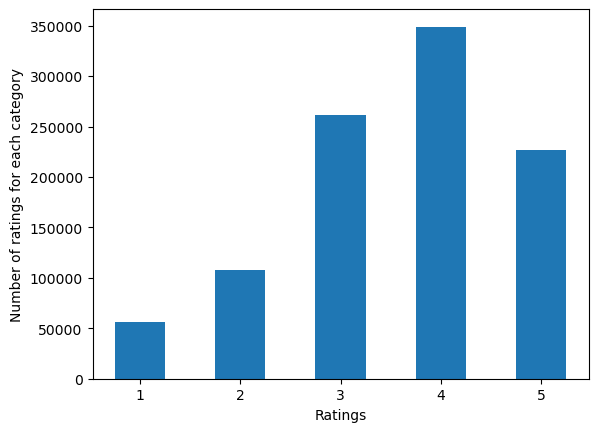

In [9]:
plt.bar(original_dts['Rating'].value_counts().index,
       original_dts['Rating'].value_counts().values, width = 0.5)
plt.xlabel('Ratings', fontsize = 10)
plt.ylabel('Number of ratings for each category', fontsize = 10)
plt.show()

In [10]:
def utility_matrix(data):
    util_matrix = []
    data = np.array(data)
    for user_nb in range(1, num_users + 1):
        id_movies = data[:, 1][data[:, 0] == user_nb]
        id_ratings = data[:, 2][data[:, 0] == user_nb]
        ratings = np.zeros(num_movies)
        ratings[id_movies - 1] = id_ratings
        util_matrix.append(list(ratings))
    return torch.FloatTensor(util_matrix)

In [11]:
train_ds = utility_matrix(training_set)
test_ds = utility_matrix(test_set)

print('Size of training set: ', train_ds.shape)
print('Size of testing set: ', test_ds.shape)

Size of training set:  torch.Size([6040, 3952])
Size of testing set:  torch.Size([6040, 3952])


In [12]:
class Activation:
    def __init__(self):
        super(Activation, self)
        
    def __call__(self, mode):
        if mode == 'relu':
            return nn.ReLU()
        if mode == 'selu':
            return nn.SELU()
        if mode == 'silu':
            return nn.SiLU()
        if mode == 'sigmoid':
            return nn.Sigmoid()

In [13]:
class Encoder(nn.Module):
    def __init__(self, 
                input_dims,
                hidden_dims1,
                hidden_dims2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dims, hidden_dims1)
        self.fc2 = nn.Linear(hidden_dims1, hidden_dims2)
        self.act = Activation()
        
    def __call__(self, x, mode):
        x = self.act(mode)(self.fc1(x))
        x = self.act(mode)(self.fc2(x))
        return x

In [14]:
class Decoder(nn.Module):
    def __init__(self,
                hidden_dims2,
                hidden_dims3, 
                output_dims):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_dims2, hidden_dims3)
        self.fc2 = nn.Linear(hidden_dims3, output_dims)
        self.act = Activation()
        
    def __call__(self, x, mode):
        x = self.act(mode)(self.fc1(x))
        output = self.fc2(x)
        return output

In [15]:
class AE(nn.Module):
    def __init__(self, 
                input_dims,
                hidden_dims1,
                hidden_dims2,
                hidden_dims3,
                output_dims):
        super(AE, self).__init__()
        self.encoder = Encoder(input_dims, hidden_dims1, hidden_dims2)
        self.decoder = Decoder(hidden_dims2, hidden_dims3, output_dims)
    
    def __call__(self, x, mode):
        x = self.encoder(x, mode)
        rebuild_x = self.decoder(x, mode)
        return rebuild_x

In [16]:
class MSELoss(nn.Module):
    def __init__(self):
        super(MSELoss, self).__init__()
    
    def __call__(self, y_pred, y_true, mask):
        loss = torch.sum(torch.pow(y_pred*mask - y_true, 2))/mask.sum()
        return loss

In [17]:
class Training:
    def __init__(self,
                input_dims,
                hidden_dims1,
                hidden_dims2,
                hidden_dims3,
                output_dims,
                num_users,
                num_movies,
                epochs,
                act_mode
                ):
        self.model = AE(input_dims,
                            hidden_dims1,
                            hidden_dims2,
                            hidden_dims3,
                            output_dims).to(device)
        self.num_users = num_users
        self.num_movies = num_movies
        self.epochs = epochs
        self.loss = MSELoss()
        self.optimizer = optim.RMSprop(self.model.parameters(),
                                       lr= 0.005, weight_decay = 1.0)
        self.act_mode = act_mode
        
    def fit(self, train_ds, test_ds):
        print("\n", 50 *"=", 'TRAINING AND EVALUATE WITH AUTO-ENCODER', 50*"=")
        print()
        for epoch in range(self.epochs):
            train_loss = 0
            s = 0
            pred_matrix = torch.zeros((self.num_users, self.num_movies))
            tr_mask = (train_ds != 0).type(torch.float)*1.
            ts_mask = (test_ds != 0).type(torch.float)*1.
            
            for user_nb in range(self.num_users):
                inputs = Variable(train_ds[user_nb]).unsqueeze(0).to(device)
                target = inputs.clone().to(device)
                mask = (target != 0).type(torch.float)*1.
                mask = mask.to(device)
                
                if torch.sum(target.data > 0) > 0:
                    outputs = self.model(inputs, self.act_mode)
                    
                    target.requires_grad = False
                    mask.requires_grad = False

                    loss = self.loss(outputs, target, mask)
                    loss.backward()
                    train_loss += loss.item()
                    s += 1
                    self.optimizer.step()
            
            for user_nb in range(self.num_users):
                inputs = Variable(train_ds[user_nb]).unsqueeze(0).to(device)
                pred_matrix[user_nb] = self.model(inputs, self.act_mode)[0]
                
            RMSE_train = torch.sqrt(self.loss(pred_matrix, train_ds, tr_mask))
            RMSE_val = torch.sqrt(self.loss(pred_matrix, test_ds, ts_mask))
            
            print(f'Epoch: {epoch + 1} -- Train_loss: {train_loss/s} -- RMSE train: {RMSE_train.item()} -- RMSE val: {RMSE_val.item()}')
            print()

In [18]:
input_dims = output_dims = train_ds.size(1)
hidden_dims1 = 200
hidden_dims2 = 100
hidden_dims3 = 200
act_mode = 'sigmoid'
epochs = 50

trainer = Training(input_dims,
                  hidden_dims1,
                  hidden_dims2,
                  hidden_dims3,
                  output_dims,
                  num_users,
                  num_movies,
                  epochs,
                  act_mode)

In [19]:
history = trainer.fit(train_ds, test_ds)


 ================================================== TRAINING AND EVALUATE WITH AUTO-ENCODER ==================================================

Epoch: 1 -- Train_loss: 1.4402687362512414 -- RMSE train: 1.0751131772994995 -- RMSE val: 1.081601858139038

Epoch: 2 -- Train_loss: 1.133828915194269 -- RMSE train: 1.0446133613586426 -- RMSE val: 1.0515714883804321

Epoch: 3 -- Train_loss: 1.0643932839177104 -- RMSE train: 1.0200390815734863 -- RMSE val: 1.0288054943084717

Epoch: 4 -- Train_loss: 1.0188953234018474 -- RMSE train: 1.0116345882415771 -- RMSE val: 1.0216435194015503

Epoch: 5 -- Train_loss: 0.9851917916896524 -- RMSE train: 0.9984331130981445 -- RMSE val: 1.0099583864212036

Epoch: 6 -- Train_loss: 0.9626909782061513 -- RMSE train: 0.9980751872062683 -- RMSE val: 1.0106172561645508

Epoch: 7 -- Train_loss: 0.945288427536752 -- RMSE train: 0.9909564852714539 -- RMSE val: 1.0048595666885376

Epoch: 8 -- Train_loss: 0.9275485146001278 -- RMSE train: 0.987352728843689 -- RMSE val:

In [20]:
def compute_top_k_accuracy(model, test_ds, num_users, top_k):
    accuracy = 0
    for user_nb in range(num_users):
        cnt = 0
        inputs = test_ds[user_nb].unsqueeze(0).to(device)
        mask = (inputs != 0).type(torch.float)*1.
        mask = mask.to(device)
        outputs = model(inputs, act_mode)
        outputs *= mask
        rec_id = torch.argsort(-outputs[0])[:top_k].cpu()
        for idx in rec_id:
            if test_ds[user_nb][idx] == 4 or test_ds[user_nb][idx] == 5:
                cnt += 1
        accuracy += cnt/len(rec_id)
    
    print('AVERAGE TOP-K ACCURACY WITH', accuracy*100/num_users)

In [21]:
compute_top_k_accuracy(trainer.model, test_ds, num_users, top_k = 10)

AVERAGE TOP-K ACCURACY WITH 69.8725165562924


In [22]:
compute_top_k_accuracy(trainer.model, test_ds, num_users, top_k = 5)

AVERAGE TOP-K ACCURACY WITH 77.54966887417451


In [23]:
def restore_matrix(model, util_matrix):
    add_matrix = torch.zeros((num_users, num_movies))
    mask = (util_matrix == 0).type(torch.float)*1.
    for user_nb in range(num_users):
        inputs = util_matrix[user_nb].unsqueeze(0).to(device)
        add_matrix[user_nb] = torch.round(model(inputs, act_mode)[0])
    add_matrix *= mask
    res_matrix = util_matrix + add_matrix
    return res_matrix

In [24]:
res_matrix = restore_matrix(trainer.model, train_ds)
print('Restore matrix:')
print(res_matrix.detach().numpy())

Restore matrix:
[[5. 4. 4. ... 4. 4. 4.]
 [5. 3. 3. ... 4. 4. 4.]
 [4. 3. 4. ... 4. 4. 5.]
 ...
 [4. 2. 3. ... 3. 4. 4.]
 [4. 3. 3. ... 4. 4. 4.]
 [3. 2. 2. ... 4. 4. 3.]]


In [25]:
def recommendations(nb_user, model, util_matrix, top_k):
    inputs = util_matrix[nb_user].unsqueeze(0).to(device)
    outputs = model(inputs, act_mode)[0]
    mask = (util_matrix[nb_user] == 0).type(torch.float)*1.
    mask = mask.to(device)
    outputs *= mask
    rec_id = torch.argsort(-outputs)[:top_k].cpu()
    rec_id = list(np.array(rec_id))
    
    print('==> ID USER: ', nb_user + 1)
    print('==> RECOMMEND: ')
    print(movies.loc[movies['MOVIE ID'].isin(rec_id)].reset_index(drop = True))

In [26]:
for i in range(20):
    print(recommendations(i, trainer.model, train_ds, top_k = 5))
    print()
    print(100*"=")
    print()

==> ID USER:  1
==> RECOMMEND: 
   MOVIE ID                         MOVIE NAME     MOVIE GENRE
0       964        Angel and the Badman (1947)         Western
1      2561                  True Crime (1999)  Crime|Thriller
2      3004               Bachelor, The (1999)  Comedy|Romance
3      3146  Deuce Bigalow: Male Gigolo (1999)          Comedy
4      3469            Inherit the Wind (1960)           Drama
None


==> ID USER:  2
==> RECOMMEND: 
   MOVIE ID                                MOVIE NAME           MOVIE GENRE
0       295         Pyromaniac's Love Story, A (1995)        Comedy|Romance
1       526  Savage Nights (Nuits fauves, Les) (1992)                 Drama
2      2323                        Cruise, The (1998)           Documentary
3      2761                    Iron Giant, The (1999)  Animation|Children's
4      3232                      Seven Chances (1925)                Comedy
None


==> ID USER:  3
==> RECOMMEND: 
   MOVIE ID                  MOVIE NAME                 